In [17]:
import pandas as pd
import matplotlib.pyplot as plt

rep_df = pd.read_csv("./Republicans_Year.csv")
dem_df = pd.read_csv("./Democrats_Year.csv")
rep_df_month = pd.read_csv("./Republicans_Month.csv")
dem_df_month = pd.read_csv("./Democrats_Month.csv")


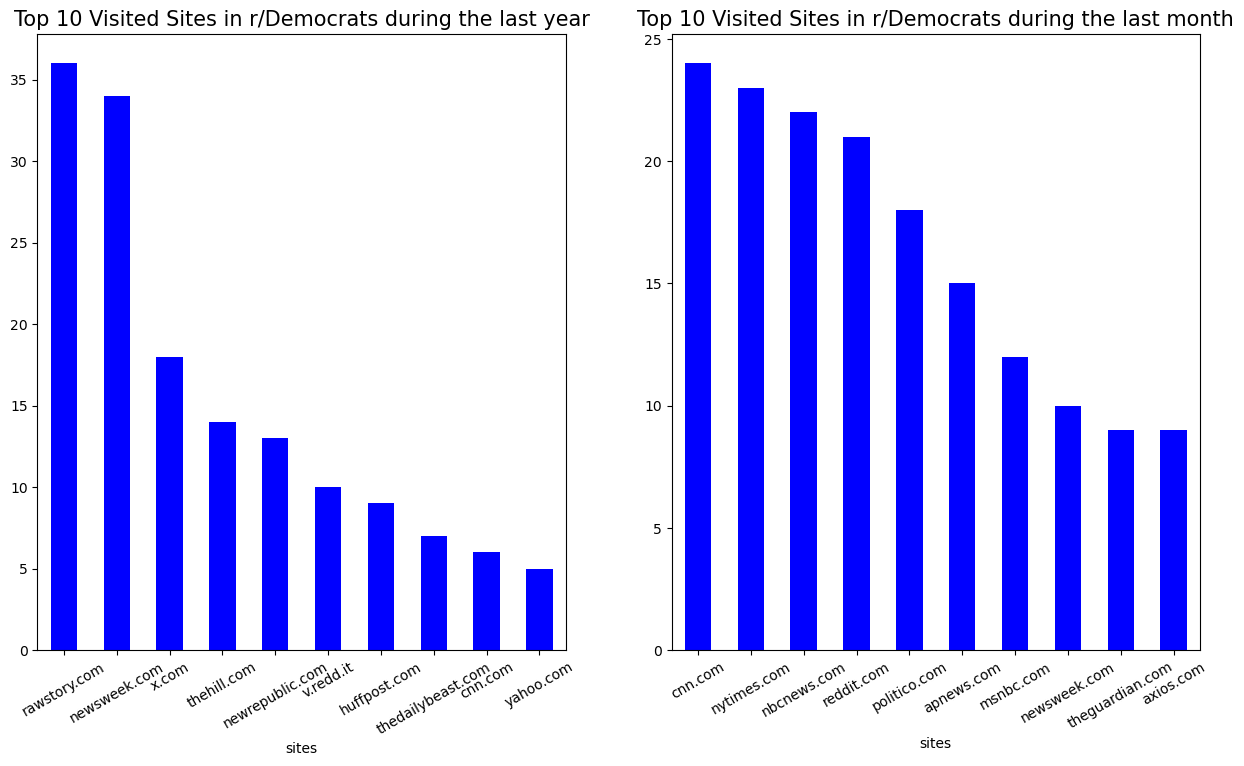

In [19]:
plt.subplot(1,2,1)
dem_df['sites'] = dem_df.url.apply(lambda x: x.replace('https://www.', '').replace('https://', '').replace('http://', '').split('/')[0])

dem_df.sites.value_counts()[2:12].plot.bar(figsize = (15, 8), rot = 30, color='blue')
plt.title('Top 10 Visited Sites in r/Democrats during the last year', fontsize = 15);

plt.subplot(1,2,2)
dem_df_month['sites'] = dem_df_month.url.apply(lambda x: x.replace('https://www.', '').replace('https://', '').replace('http://', '').split('/')[0])

dem_df_month.sites.value_counts()[3:13].plot.bar(figsize = (15, 8), rot = 30, color='blue')
plt.title('Top 10 Visited Sites in r/Democrats during the last month', fontsize = 15);


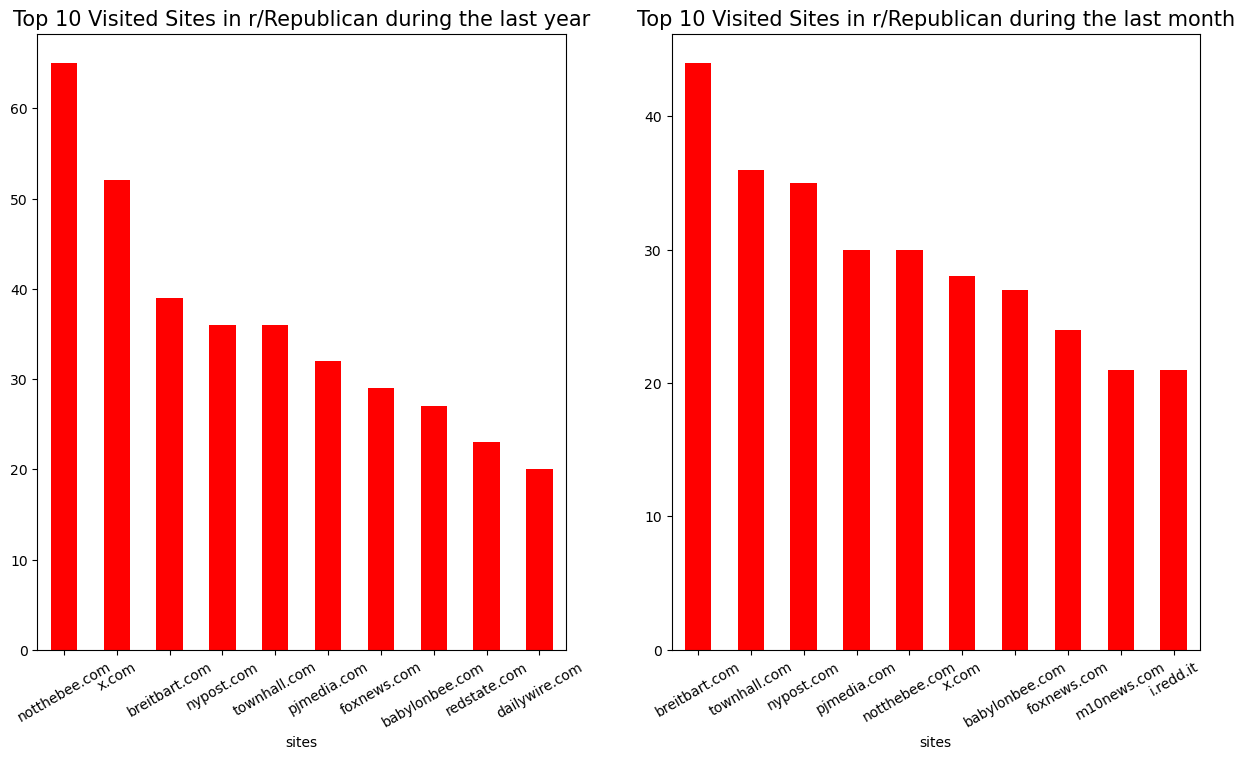

In [21]:
plt.subplot(1,2,1)
rep_df['sites'] = rep_df.url.apply(lambda x: x.replace('https://www.', '').replace('https://', '').replace('http://', '').split('/')[0])

rep_df.sites.value_counts()[2:12].plot.bar(figsize = (15, 8), rot = 30, color='red')
plt.title('Top 10 Visited Sites in r/Republican during the last year', fontsize = 15);

plt.subplot(1,2,2)
rep_df_month['sites'] = rep_df_month.url.apply(lambda x: x.replace('https://www.', '').replace('https://', '').replace('http://', '').split('/')[0])

rep_df_month.sites.value_counts()[2:12].plot.bar(figsize = (15, 8), rot = 30, color='red')
plt.title('Top 10 Visited Sites in r/Republican during the last month', fontsize = 15);



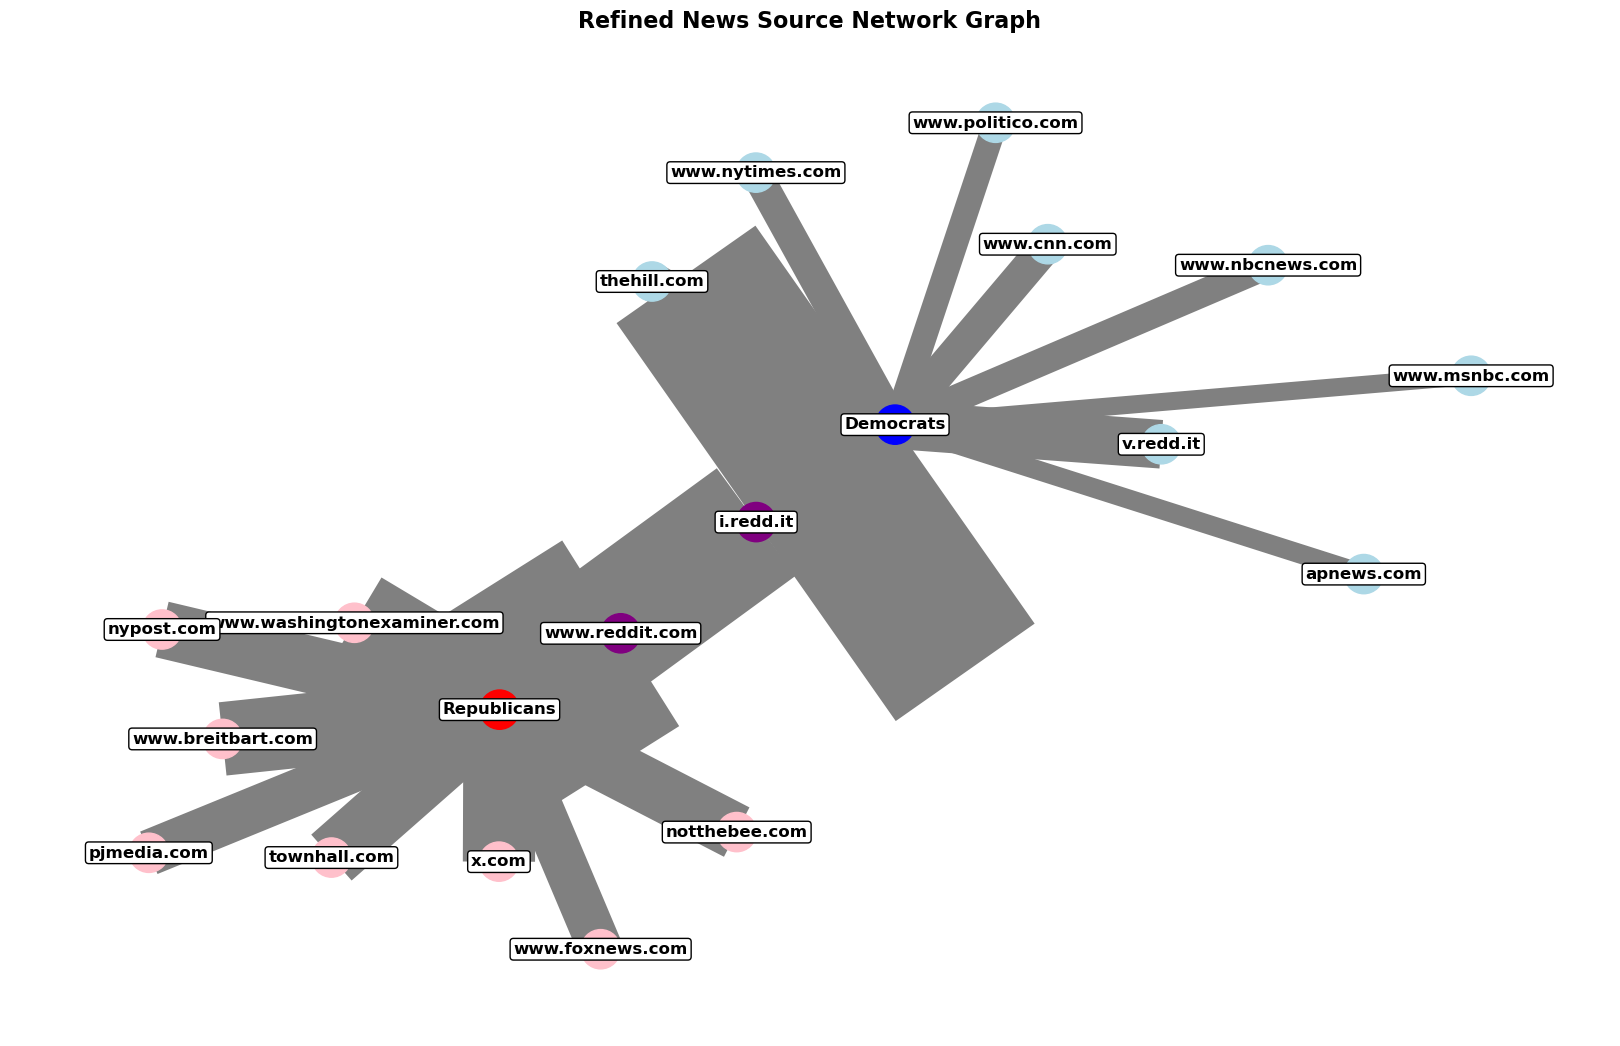

In [23]:
import pandas as pd
from urllib.parse import urlparse
import networkx as nx
import matplotlib.pyplot as plt


data = pd.read_csv('RPAFINAL.csv')

data['domain'] = data['url'].apply(lambda x: urlparse(x).netloc if pd.notnull(x) else None)
domain_usage = data.groupby(['subreddit', 'domain']).size().reset_index(name='count')

# Top 10 News Sources for Each Subreddit
top_democrats = domain_usage[domain_usage['subreddit'] == 'democrats']\
    .sort_values(by='count', ascending=False).head(10)
top_republicans = domain_usage[domain_usage['subreddit'] == 'Republican']\
    .sort_values(by='count', ascending=False).head(10)

top_democrats_domains = set(top_democrats['domain'])
top_republicans_domains = set(top_republicans['domain'])
top_shared_domains = top_democrats_domains & top_republicans_domains

# Create Refined Network Graph
G_refined = nx.Graph()

# Add Nodes and Edges for Democrats
for _, row in top_democrats.iterrows():
    domain = row['domain']
    G_refined.add_node(domain, type='domain', group='democrats', count=row['count'])
    G_refined.add_edge(domain, 'Democrats', weight=row['count'])

# Add Nodes and Edges for Republicans
for _, row in top_republicans.iterrows():
    domain = row['domain']
    G_refined.add_node(domain, type='domain', group='republicans', count=row['count'])
    G_refined.add_edge(domain, 'Republicans', weight=row['count'])

# Mark Shared Domains
for domain in top_shared_domains:
    if G_refined.has_node(domain):
        G_refined.nodes[domain]['group'] = 'shared'

# Node colours
node_colors_refined = []
for node, data in G_refined.nodes(data=True):
    if node == 'Democrats':
        node_colors_refined.append('blue')
    elif node == 'Republicans':
        node_colors_refined.append('red')
    elif data['group'] == 'shared':
        node_colors_refined.append('purple')  # Shared sources as purple
    elif data['group'] == 'democrats':
        node_colors_refined.append('lightblue')  # Democrat sources as light blue
    elif data['group'] == 'republicans':
        node_colors_refined.append('pink')  # Republican sources as pink

pos_refined = nx.spring_layout(G_refined, seed=42)
for node in G_refined.nodes:
    if node == 'Democrats':
        pos_refined[node][0] = -1  # Far left
    elif node == 'Republicans':
        pos_refined[node][0] = 1  # Far right
    elif G_refined.nodes[node].get('group') == 'democrats':
        pos_refined[node][0] = -0.5  # Left
    elif G_refined.nodes[node].get('group') == 'republicans':
        pos_refined[node][0] = 0.5  # Right
    elif G_refined.nodes[node].get('group') == 'shared':
        pos_refined[node][0] = 0  # Center
        
plt.figure(figsize=(16, 10))  
pos_refined = nx.spring_layout(G_refined, seed=42, k=0.4)
nx.draw(
    G_refined, pos=pos_refined,
    with_labels=False,  
    node_color=node_colors_refined,
    node_size=800,
    edge_color='gray',
    width=[d['weight'] for u, v, d in G_refined.edges(data=True)]
)
# Add adjusted labels
labels = {node: node for node in G_refined.nodes}
nx.draw_networkx_labels(
    G_refined, pos=pos_refined,
    labels=labels,
    font_size=12,  
    font_weight='bold',  
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

plt.title("Refined News Source Network Graph", fontsize=16, fontweight='bold')  
plt.show()
